# Keypoints Detection for Animal Footprints

## Table of Contents
* [Overview](#Overview)
* [Set the Environment](#Set-the-environment)
* [Load and Process Data](#Load-and-process-data)
* [Build the Model](#Build-the-model)
* [Train the Model](#Train-the-model)
* [Predict Keypoints](#Predict-keypoints)
* [Visualize Keypoints](#Visualize-keypoints)
* [Conclusion](#Conclusion)

## Overview <a id="Overview"></a>
This notebook illustrates how to use CNNs to estimate keypoints in image-based data. In particular, we will estimate the position of keypoints on animal footprint images. 

The data is sourced from a WildTrack project in which SAS incorporated with WildTrack organization over footprint identification techinque(FIT). The image and keypoint data has been provided in a .sashdat file:

1. 676 color images with a single footprint in each image. The images have been cropped to be 224 x 224 pixels.
2. Each image uses 25 keypoints to describe the footprint. Each keypoint is specified by an (x,y) pair normalized in range of -1 to 1 with (0,0) denoting the center of the image.

Conceputally, we will formulate the problem as CNN-based regression task for the x and y value of each keypoint.

## Set the Environment <a id="Set-the-environment"></a>
We import swat to manage our connection to CAS, dlpy for high-level access to deep learning tools and cv2 to help mark the predicted keypoints.

In [1]:
from swat import *

from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.images import *
from dlpy.model import *
from dlpy.lr_scheduler import *
from dlpy.network import *

import cv2

### Connect to CAS
Be sure to specify **`server_machine`** and **`server_port`**

In [2]:
server_machine = 'cloud.example.com'
server_port = '5570'
conn = CAS(server_machine, server_port)
conn.loadactionset('deepLearn')
conn.loadactionset('image')

NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'image'.


[actionset]

 'image'

+ Elapsed: 0.0557s, user: 0.002s, sys: 0.001s, mem: 0.238mb

## Load and Process Data <a id="Load-and-process-data"></a>
We first specify the path to the sashdat file with the data. To use the loadTable action, the data must be in a directory accessible by the CAS host. The *`caslibify()`* function assigns the appropriate caslib and file name for use by the loadTable action.

In [3]:
data_path = '/path/to/data/wildtrack_species_landmarks.sashdat'
data_caslib, data_file_name, _ = caslibify(conn=conn, path=data_path, task='load')
conn.loadtable(caslib=data_caslib, path=data_file_name,
            casout=dict(name='landmark', replace=1), where='nl_x24 ne .')

NOTE: Cloud Analytic Services made the file wildtrack_species_landmarks.sashdat available as table LANDMARK in caslib CASUSER(user).


[caslib]

 'CASUSER(user)'

[tableName]

 'LANDMARK'

[casTable]

 CASTable('LANDMARK', caslib='CASUSER(user)')

+ Elapsed: 6.69s, user: 1.29s, sys: 1.01s, mem: 71.8mb

### Create ImageTable
Though the table is loaded into memory in our CAS session, it's still not associated with any Python objects. We use the **`from_table()`** method to build an ImageTable from the data in CAS. Remember, however, there are 25 keypoints we need to copy to the ImageTable. Each keypoint has an x and y value so there are 50 total variables in the table that need to be copied to the ImageTable. The `columns` parameter of **`from_table`** allows us to copy them. For convenience, we define `targets` as a list of these variables. In our case, these variables correspond to the last 50 columns of the in-memory table. 

In [4]:
targets = list(conn.columninfo('landmark').ColumnInfo.Column.values[-50:])
dataset = ImageTable.from_table(label_col='species', tbl=conn.CASTable('landmark'), columns=targets)

### Split Data into Testing and Training
Using the **`resize`** method, we ensure all images are 224 x 224. Then we use **`two_way_split`** to split the data into a training set and a test set, putting roughly 1/10 of the observations into the test set.

In [5]:
dataset.resize(224, columns=targets)
trainset, testset = two_way_split(tbl=dataset, test_rate=10, im_table=False, stratify=False)

## Build the Model <a id="Build-the-model"><a/>

Next, let's build a CNN model. Ultimately, our network will feed into a keypoints layer which is responsible for calculating regression error and backpropagating gradients. However, we can use any feature extractor to feed into the keypoints layer. We choose to use ResNet18 as the backbone of our model. Note that the ResNet model assumes a classification output and therefore requires an **`n_classes`** parameter. We will  replace this layer with the keypoints layer, so it doesn't matter what number we supply so long as it is valid.

In [6]:
dummy_class_number = 2
resnet18_model = ResNet18_Caffe(conn, n_classes=dummy_class_number, random_crop='none', random_mutation='RANDOM')

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Pooling layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


### ResNet Backbone
To use a ResNet backbone with the keypoints layer, we will take advantage of DLPy's functional API. This means we will treat layers (and models) as functions that act on tensors and return tensors. 
1. Use **`to_functional_model`** method with **`stop_layers`** argument. By using **`stop_layers`** to select the last layer of resnet18_model, we strip classifier layer and save the feature extraction portion to resnet18_backbone.
2. Create an input tensor designed to be fed into the resnet18_backbone model.
3. Use a functional call of the resnet18_backbone model on input_ to create the resnet18_backbone_out which will serve as input tensor into the keypoints layer.

In [7]:
resnet18_backbone = resnet18_model.to_functional_model(stop_layers=resnet18_model.layers[-1])

In [8]:
input_ = Input(**resnet18_backbone.layers[0].config, name='input')
resnet18_backbone_out = resnet18_backbone(input_)

### Keypoints Layer
The keypoints layer allows you to specify the error function and the number of neurons. In this case, **`n`** (number of neurons) is set as 50 because there will be at most 25 landmarks on each image and each of landmarks requires two value, x and y, to describe the location. 

We create the layer and make a functional call of that layer on its input tensor, resnet18_backbone_out, in order to create the output tensor, keypoints_out. 


In [9]:
keypoints_layer = Keypoints(n=50, name='kp1')
keypoints_out = keypoints_layer(resnet18_backbone_out)

### Compile Model
We now have a composition of models and layers from input_ tensor to keypoints_out tensor. We create a Model object from that composition and compile it to invoke the CAS actions required to build the model in memory.

In [10]:
keypoints_model = Model(conn, inputs=input_, outputs=keypoints_out, model_table='keypoints_model')
keypoints_model.compile()

NOTE: Model compiled successfully.


### Plot network
To enable graphic visualizations of DLPy deep learning models, it is recommended that you download and install the open source graph visualization software called Graphviz. <br>
Graphviz is available at https://www.graphviz.org/download/.

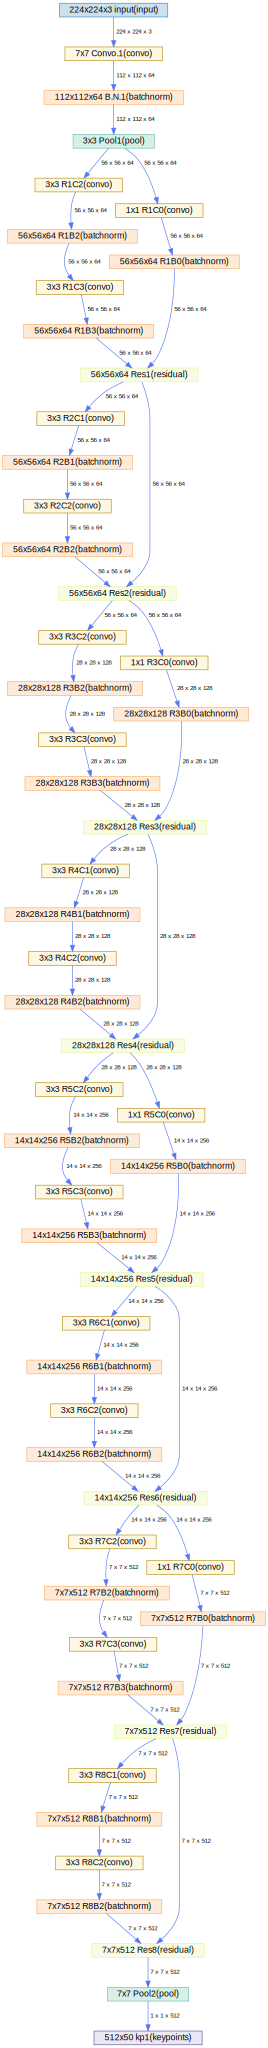

In [11]:
keypoints_model.plot_network()

### Load pre-trained weights if available
To facillitate training speed, you can load weights to the ResNet18 portion of your model. Be sure to change **`init_weights_path`** to the sashdat file containing the model weights.

In [12]:
initial_weights_path = '/path/to/weights/RESNET18_CAFFE_weights.sashdat'
initial_weights_caslib, initial_weights_file_name, _ = caslibify(conn=conn, path=initial_weights_path, task='load')

conn.loadtable(caslib = initial_weights_caslib, path=initial_weights_file_name,
               casout=dict(name='initial_weights', replace=1))

if conn.table.tableexists(name='initial_weights').exists:
    keypoints_model.set_weights('initial_weights')

NOTE: Cloud Analytic Services made the file RESNET18_CAFFE_weights.sashdat available as table INITIAL_WEIGHTS in caslib CASUSER(user).
NOTE: Model weights attached successfully!


## Train the Model <a id="Train-the-model"></a>
Because the model trains with both image data and numeric nominal data, we specify the input using the data_specs option. Using this option, we can bind the images to the input layer and the targets to the keypoints layer.

In [13]:
optimizer = Optimizer(mini_batch_size=12, log_level=2, max_epochs=10, reg_l2=0.0005,
                      algorithm=MomentumSolver(clip_grad_max=100, clip_grad_min=-100,
                                               learning_rate=0.000001, step_size=30))
data_specs = [DataSpec(type_='IMAGE', layer='input', data=['_image_']),
              DataSpec(type_='numnom', layer='kp1', data=targets)]
keypoints_model.fit(data=trainset, optimizer=optimizer,
                    data_specs=data_specs,
                    #gpu=dict(devices=0),
                    n_threads = 5)

NOTE: Training based on existing weights.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 11206386.
NOTE:  The approximate memory cost is 3471.00 MB.
NOTE:  Loading weights cost       0.44 (s).
NOTE:  Initializing each layer cost       2.41 (s).
NOTE:  The total number of threads on each worker is 5.
NOTE:  The total mini-batch size per thread on each worker is 12.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 60.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          1E-6           153.7      307.5   111.32
NOTE:  1          1E-6           130.2      260.4   110.72
NOTE:  2          1E-6           104.3      208.5   111.08
NOTE:  3          1E-6           83.45      166.9   111.41
NOTE:  4          1E-6              65        130   111.18
NOTE:  5          1E-6           51.62      103.2   110.81
NOTE:  6      

,Descr,Value
0,Model Name,keypoints_model
1,Model Type,Convolutional Neural Network
2,Number of Layers,54
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,21
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,21
9,Number of Residual Layers,8


## Predict Keypoints <a id="Predict-keypoints"></a>
Here we assign predictions for the keypoints for the images in the test data set. This outputs a table in CAS and also stores the results as the **`valid_res_tbl`** attribute of keypoints_model.

In [14]:
keypoints_model.predict(data=testset)

NOTE: Due to data distribution, miniBatchSize has been limited to 3.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            68
 1  Number of Observations Used            68
 2           Mean Squared Error      40.07978
 3                   Loss Error      20.03989

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(user)  Valid_Res_uV3IZs    68      103   
 
                                             casTable  
 0  CASTable('Valid_Res_uV3IZs', caslib='CASUSER(k...  

+ Elapsed: 5.44s, user: 34.7s, sys: 1.55s, mem: 2.86e+03mb

## Visualize Keypoints <a id="Visualize-keypoints"></a>
Here, we define a helper function to plot predictions. The helper function uses the predicted keypoints to calculate the elements in the array that correspond to the keypoints. Using those elements and the cv2.circle function, the image array is altered so that a red circle appears at each keypoint. The images are plotted with matplotlib.pyplot.imshow().

In [15]:
def plot_landmarks(conn, data, targets, image_list=range(4), n_col=2, figsize=None):
    import cv2
    targets.sort(key=lambda x: int(x[max(x.find('x'), x.find('y')) + 1:]))
    n_images = len(image_list)
    num_obs = min(conn.numrows(data)['numrows'], n_images)
    res_img = conn.fetchimages(table=data, to=num_obs).Images
    res_label = conn.fetch(data, fetchvars=targets, to=num_obs).Fetch

    if n_images > n_col:
        n_row = n_images // n_col + 1
    else:
        n_row = 1
        n_col = n_images

    if figsize is None:
        figsize = (16, 16 // n_col * n_row)

    fig = plt.figure(figsize=figsize)

    idx_img = 1
    for i in image_list:
        img = res_img.loc[i, 'Image']
        img_arr = np.array(img)
        circle_size = int(min(img_arr.shape[:2])/40)
        for k in range(0, len(targets), 2):
            x = int(res_label.loc[i, targets[k]] * res_img.loc[i, 'Width'] / 2 + res_img.loc[i, 'Width'] / 2)
            y = int(res_label.loc[i, targets[k + 1]] * res_img.loc[i, 'Height'] / 2 + res_img.loc[i, 'Height'] / 2)
            cv2.circle(img_arr, (x, y), circle_size, (255, 0, 0), -1)
        ax = fig.add_subplot(n_row, n_col, idx_img)
        plt.imshow(img_arr, cmap='gray')
        # plt.title (str(r['Images']['_path_'].loc[i].split('.')[0]))
        idx_img = idx_img + 1
        plt.xticks([]), plt.yticks([])
    plt.show()

NOTE: Table VALID_RES_UV3IZS contains compressed images.


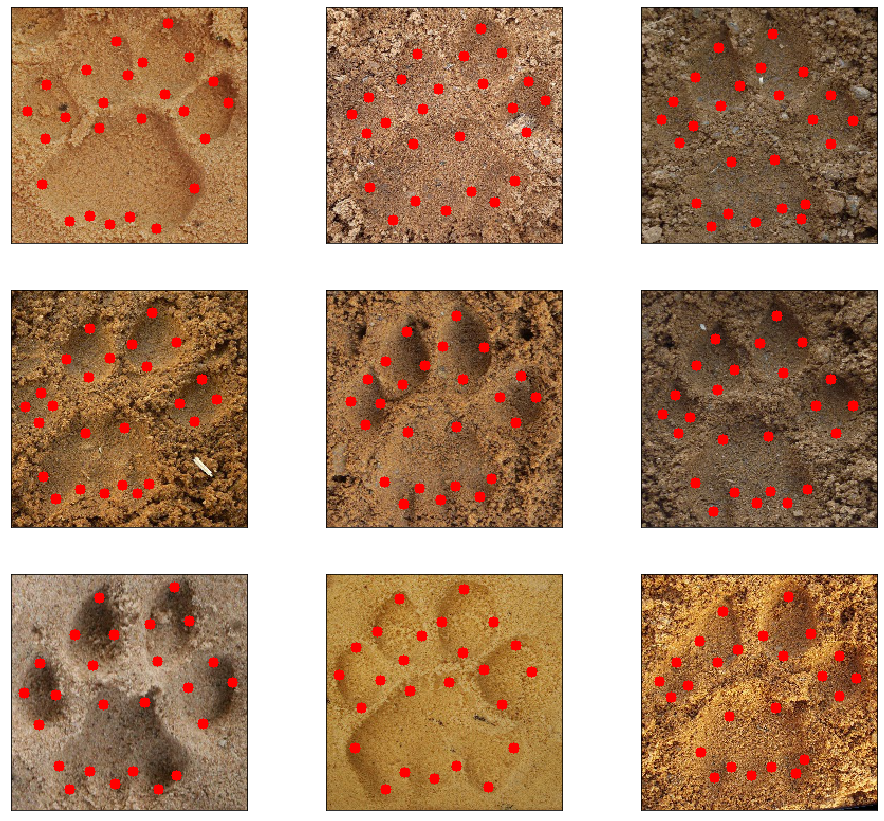

In [16]:
plot_landmarks(conn, keypoints_model.valid_res_tbl, targets=targets, image_list=range(9), n_col=3)

## Conclusion <a id="Conclusion"></a>
The model performs quite well from a purely visual perspective. The keypoints in each pawprint seem to be consistent, but we will need to evaluate an appropriate scoring metric to have a rigorous assessment of our model.

### More applications of keypoint detection
Keypoint detection has many applications. For instance, Alibaba launched the FashionAI competition this year. The competition concentrates on the key point localization of women's apparel.

Keypoint detection should be considered for any multiple regression problem with interval targets.

In [17]:
conn.endsession()

+ Elapsed: 0.000372s, mem: 0.221mb